## Data Cleaning

The objective of this notebook is to clean the project data set for analytic purpose. 
- Rename columns if necessary
- Identify outliers
- Impute any missing values with domain knowledge
- Identify missing values
- Create new field if needed

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# import data for cleaning
df = pd.read_csv('../data/crime.csv')
df = df.loc[~df['DR_NO'].isnull()]

C:\Users\Norman\AppData\Local\Temp\ipykernel_2432\3940787274.py:2: DtypeWarning: Columns (1,2,5,9,10,12,13,15,17,18,19,24,25) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('../data/crime.csv')


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 50397 entries, 0 to 50396
Data columns (total 28 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   DR_NO           50397 non-null  float64
 1   Date Rptd       50397 non-null  object 
 2   DATE OCC        50397 non-null  object 
 3   TIME OCC        50397 non-null  float64
 4   AREA            50397 non-null  float64
 5   AREA NAME       50397 non-null  object 
 6   Rpt Dist No     50397 non-null  float64
 7   Part 1-2        50397 non-null  float64
 8   Crm Cd          50397 non-null  float64
 9   Crm Cd Desc     50397 non-null  object 
 10  Mocodes         43598 non-null  object 
 11  Vict Age        50397 non-null  float64
 12  Vict Sex        43944 non-null  object 
 13  Vict Descent    43942 non-null  object 
 14  Premis Cd       50396 non-null  float64
 15  Premis Desc     50375 non-null  object 
 16  Weapon Used Cd  18221 non-null  float64
 17  Weapon Desc     18221 non-null  obje

### Rename Columns

In [4]:
# replace column names with standardize format
col_names = {'DR_NO':'crimeID',
             'Date Rptd':'reportDate',
             'DATE OCC':'eventDate',
             'TIME OCC':'eventTime',
             'AREA NAME':'areaName',
             'Crm Cd Desc':'crimeDesc',
             'Vict Age':'victimAge',
             'Vict Sex':'victimSex',
             'Premis Desc':'permisDesc',
             'Status Desc':'statusDesc',
             'LAT':'lat',
             'LON':'lon'}

col = ['DR_NO', 'Date Rptd', 'DATE OCC', 'TIME OCC',
        'AREA NAME', 'Crm Cd Desc', 'Vict Age', 'Vict Sex',
        'Premis Desc', 'Status Desc', 'LAT', 'LON']

rename = df[col].rename(columns=col_names)

In [5]:
rename.head()

,crimeID,reportDate,eventDate,eventTime,areaName,crimeDesc,victimAge,victimSex,permisDesc,statusDesc,lat,lon
0,190326475.0,3/1/2020 0:00,3/1/2020 0:00,2130.0,Wilshire,VEHICLE - STOLEN,0.0,M,STREET,Adult Arrest,34.0375,-118.3506
1,200106753.0,2/9/2020 0:00,2/8/2020 0:00,1800.0,Central,BURGLARY FROM VEHICLE,47.0,M,BUS STOP/LAYOVER (ALSO QUERY 124),Invest Cont,34.0444,-118.2628
2,200320258.0,11/11/2020 0:00,11/4/2020 0:00,1700.0,Southwest,BIKE - STOLEN,19.0,X,"MULTI-UNIT DWELLING (APARTMENT, DUPLEX, ETC)",Invest Cont,34.0210,-118.3002
3,200907217.0,5/10/2023 0:00,3/10/2020 0:00,2037.0,Van Nuys,SHOPLIFTING-GRAND THEFT ($950.01 & OVER),19.0,M,CLOTHING STORE,Invest Cont,34.1576,-118.4387
4,220614831.0,8/18/2022 0:00,8/17/2020 0:00,1200.0,Hollywood,THEFT OF IDENTITY,28.0,M,SIDEWALK,Invest Cont,34.0944,-118.3277


### Identify and Replace Outliers

- Victim age should not be 0, negative, nor over 100

<Axes: xlabel='victimAge', ylabel='Count'>

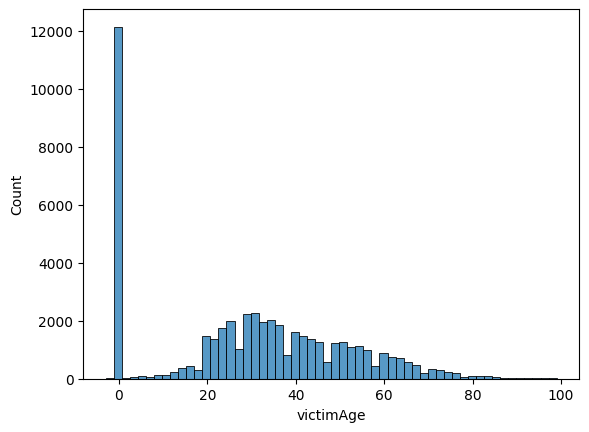

In [6]:
sns.histplot(data=rename, x='victimAge')

Three simple options to handle such issue:
1. replace all outliers with NULL (wasting data)
2. replace all outliers with some representable values (mean, median, mode)
3. replace all outliers with some modeled estimation 

There are many technical ways to handle outliers, please dig into it youself.  

In [7]:
# replace outliers with median
median = rename['victimAge'].median()
outliers = rename
outliers.loc[(outliers['victimAge']<=0) | (outliers['victimAge']>80), 'victimAge'] = median


### Identify and Replace Any Missing Value

- Victim sex contains missing values

In [13]:
print(f"Total Number of Missing: {outliers.loc[outliers['victimSex'].isnull()]['crimeID'].count()}")

Total Number of Missing: 6453


Again, there are many different technical methods to replace missing value. You should explore different methods that best fit for the scenario. 

In [8]:
# replace missing values with mode
crime_mode = outliers.groupby('crimeDesc', as_index=False)['victimSex'].value_counts()
crime_max = crime_mode.groupby('crimeDesc', as_index=False)['count'].max()
victim_sex = (crime_mode.merge(crime_max, 
                              on=['crimeDesc', 'count'], 
                              how='inner')[['crimeDesc', 'victimSex']]
                              .rename(columns={'victimSex':'sex'})
)

missing = outliers.merge(victim_sex, on='crimeDesc', how='left')
missing.loc[missing['victimSex'].isnull(), 'victimSex'] = missing['sex']
missing = missing.drop(columns=['sex'])


### Create a New Field for Analytic

- Track how long people report the crime after happended


In [9]:
# calculate the days of report after the crime happended
missing['reportDate'] = pd.to_datetime(missing['reportDate'])
missing['eventDate'] = pd.to_datetime(missing['eventDate'])
missing['dayDiff'] = missing['reportDate'] - missing['eventDate']


### End of the cleaning process  

As a professional, you may want to add some data checker at the end of the process to make sure the data behave as expected. 

In [14]:
assert missing['victimAge'].max()<=80, 'Victim Age is over 80'
assert missing['victimAge'].min()>0, 'Victim Age is equal or less than 0' 